In [49]:
#Install spacy if not already installed in your python environment (remove the # symbol to do this)
#!pip install spacy
#!pip install wordcloud

In [20]:
# Import necessary modules
import json
#import string
import spacy
#import subprocess
import subprocess
import pandas as pd
import numpy as np
import string
from collections import Counter
from tabulate import tabulate
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import seaborn as sns

# Install the model 'en_core_web_sm' model using the command-line interface
subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_md'])

# Load the installed model
nlp = spacy.load('en_core_web_md')

##### SELECT SECTION OF INTEREST - SAFEGUARDING CHILDREN LEVEL 2

In [21]:
# Select section of interest from json file
# List of page number containing section of interest
pages_of_interest = [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

# Open the json file
with open('training_booklet.json', 'r') as booklet:
    # Parse the JSON data from the line
    booklet_pages = json.load(booklet)
    
    # Create a list to store lines of the json file containing raw section we are interested in and also a list to store preprocessed version of this section
    section_of_interest = []
    
    # Iterate over each line of the json file
    for page_number, page_content in booklet_pages.items():
        
        # Check if the page number is in the list of interested section
        if int(page_number) in pages_of_interest:
            
            # Add the content of that page to section 
            section_of_interest.append(page_content)
            
# Print just the first page of the raw section 
print(section_of_interest[0])

Safeguarding children training (Level 2) Regulations CQC - Outcome 7 Welcome to the safeguarding children training Level 2. This briefing is for the purpose of updating Mid Essex Hospital Services NHS Trust staff only. To become fully compliant with Level two training you are required to read the written briefing and complete the attached quiz and return to the Training and Development department. Level two safeguarding children training is required for "All non-clinical and clinical staff who have any contact with children, young people and/or parents/carers" Safeguarding children and young people: roles and competences for health care staff: Intercollegiate Document, March 2014. The purpose of this briefing is to support you in understanding what is meant by Safeguarding Children and Child protection, the different ways a child or young person may be abused or neglected and what actions you should take if you have concerns that a child is being harmed. Please be aware that "doing not

##### TEXT SUMMARIZATION AND COMMON THEME EXTRACTION

In [40]:
# Combine the pages of this section of interest into a single string of texts, i.e removing page seperators
section_combined = ' '.join(section_of_interest)


# Preprocess the text by removing stopwords, punctuation, and perform lemmatization
preprocessed_text = ' '.join([token.lemma_ for token in nlp(section_combined) if not token.is_stop and not token.is_punct])
#preprocessed_text = ' '.join([token.text for token in nlp(section_combined) if not token.is_stop])

# Function to generate a summary using extractive text summarization
def generate_summary(text, word_freq, num_sentences=5):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    # Calculate the importance of each sentence based on word frequency
    sentence_scores = {sent: sum(token.text.lower() in word_freq.keys() for token in nlp(sent)) 
                       for sent in sentences}
    # Select top sentences based on importance
    top_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:num_sentences]
    return ' '.join(top_sentences)

# Function to extract common themes from the text
def extract_common_themes(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    common_themes = Counter(entities)
    sorted_themes = common_themes.most_common()
    return sorted_themes

# Extract word frequencies from the preprocessed text
word_freq = Counter(preprocessed_text.split())

# Generate a summary of the text
summary = generate_summary(section_combined, word_freq)

# Extract common themes from the text
common_themes = extract_common_themes(preprocessed_text)

# Print the summary and common themes
print("Summary:")
print(summary)

print("\nCommon Themes:")
for theme, freq in common_themes:
    common_theme = pd.DataFrame(common_themes, columns=['Common themes', 'Number of mentions'])
print(tabulate(common_themes, headers=['Common themes', 'Number of mentions'], tablefmt='grid'))
#print(common_theme.head(114))

Summary:
Which services may offer support to the family if level two (Additional); they will provide contact details  Identify that Family Solutions criteria is met and discuss how to refer to the Family solutions team if level three (Intensive) or  Transfer you to the Initial response team if it is considered that the child is at risk of significant harm (Specialist) Please refer to the Essex Windscreen over the page for explanation of levels and follow the yellow pathway if the family require additional support. If you work with the parents and carers only This list identifies adult issues which are known to have an impact on their capacity to parent effectively: Mental Health or Learning disability Alcohol misuse Substance misuse Domestic abuse Family history Financial Problems Chronic Ill health Complex social problems Social isolation Early parenthood Should you concerned about the adults presentation to the hospital, consider: . The impact includes:  Children may get caught in th

##### NAMED ENTITY RECOGNITION

In [41]:
# Process the Preprocessed text
process_doc = nlp(section_combined)

# Initialize an empty list to store named entities and their types
named_entities =[]
    
    # Extract named entities and their types using the RAW SECTION OF INTEREST
for entity in process_doc.ents:
     # Extract the text and label of the named entity
    entity_name = entity.text
    entity_label = entity.label_
    
     # Create a tuple of the text and label and append it to the list
    named_entity_tuple = (entity_name, entity_label)
    named_entities.append(named_entity_tuple)

print(tabulate(named_entities, headers=['Entity Name', 'Entity Type'], tablefmt='grid'))
ner_df = pd.DataFrame(named_entities, columns=['Entity Name', 'Entity Type'])
#print(ner_df)

+---------------------------------------------------------+---------------+
| Entity Name                                             | Entity Type   |
+=========================================================+===============+
| 2                                                       | CARDINAL      |
+---------------------------------------------------------+---------------+
| 7                                                       | CARDINAL      |
+---------------------------------------------------------+---------------+
| Mid Essex Hospital Services                             | ORG           |
+---------------------------------------------------------+---------------+
| NHS Trust                                               | ORG           |
+---------------------------------------------------------+---------------+
| two                                                     | CARDINAL      |
+---------------------------------------------------------+---------------+
| the Traini

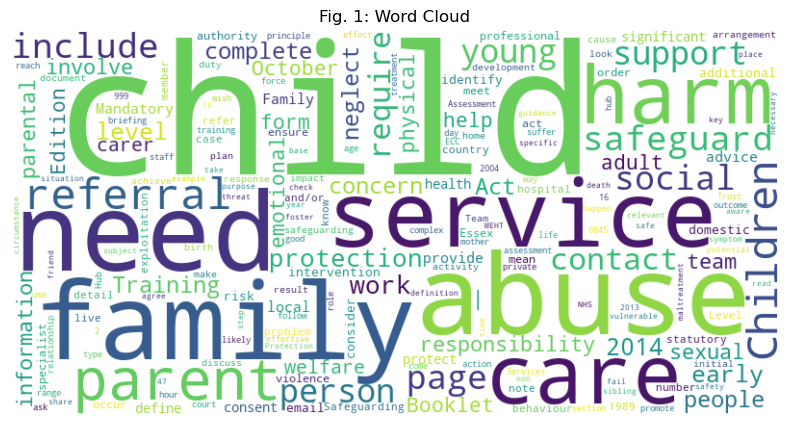

In [42]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fig. 1: Word Cloud')
plt.show()

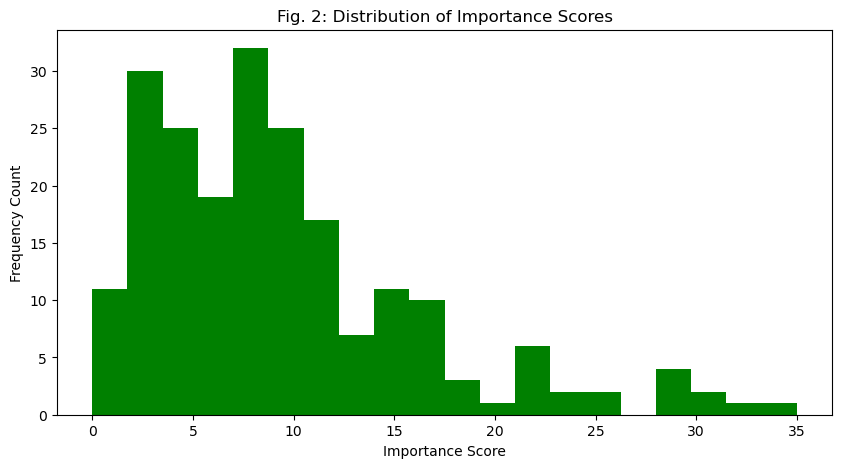

In [43]:
# Calculate the importance of each sentence based on word frequency
doc = nlp(section_combined)
sentences = [sent.text for sent in doc.sents]
# Calculate the importance of each sentence based on word frequency
sentence_scores = {sent: sum(token.text.lower() in word_freq.keys() for token in nlp(sent)) 
                       for sent in sentences}

# Plot a histogram of importance scores
plt.figure(figsize=(10, 5))
plt.hist(list(sentence_scores.values()), bins=20, color='green')
plt.xlabel('Importance Score')
plt.ylabel('Frequency Count')
plt.title('Fig. 2: Distribution of Importance Scores')
plt.show()

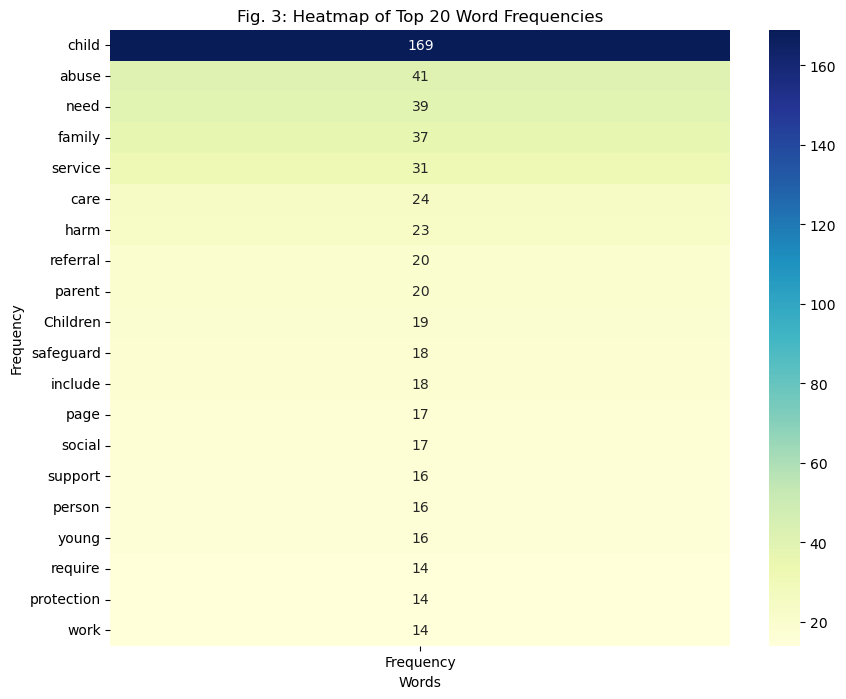

In [44]:
# Convert word frequency dictionary to DataFrame
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])

# Plot a heatmap of word frequencies
plt.figure(figsize=(10, 8))
sns.heatmap(df_word_freq.sort_values(by='Frequency', ascending=False)[:20], cmap='YlGnBu', annot=True, fmt='d')
plt.title('Fig. 3: Heatmap of Top 20 Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()